In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/data.nii.gz')
mask_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/nodif_brain_mask.nii.gz')
mask_100307_long_pro = process_data.get_mask_pro(scan_100307, mask_100307)

In [3]:
normalized_scan_100307_full = np.load(config.norm_data_path + '/normalized_scan_100307_full.npy')

In [4]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals')

In [27]:
selected_indice = [ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271]

In [28]:
bvals_100307_selected = bvals_all_100307[selected_indice]*1e-3

In [29]:
normalized_scan_100307_sub = normalized_scan_100307_full[:,selected_indice]

In [30]:
big_b_bvals_100307_selected = np.where(bvals_100307_selected != 0.005)[0]

In [31]:
normalized_scan_100307_sub_no_b5 = normalized_scan_100307_sub[:, big_b_bvals_100307_selected]
bvals_100307_selected_no_5 = bvals_100307_selected[big_b_bvals_100307_selected]

In [32]:
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')
n_100307_sub = n_all_100307[:,selected_indice]
n_100307_sub_no_b5 = n_100307_sub[:,big_b_bvals_100307_selected].T
print(n_100307_sub_no_b5.shape)

b_values_100307_sub = torch.FloatTensor(bvals_100307_selected_no_5)
gradient_directions_100307_sub = torch.FloatTensor(n_100307_sub_no_b5)

(105, 3)


In [33]:
net = network.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub)
net.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/Models/model_100206_7g_04.pt"))
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=105, out_features=105, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=105, out_features=105, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=105, out_features=105, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=105, out_features=105, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=105, out_features=105, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=105, out_features=105, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=105, out_features=5, bias=True)
  )
)

In [34]:
X_100307_pred, theta_100307_pred, phi_100307_pred, mu_cart_100307_pred, lambda_par_100307_pred, lambda_iso_100307_pred,  volume_0_100307_pred, volume_1_100307_pred = net(torch.from_numpy(normalized_scan_100307_sub_no_b5.astype(np.float32)))

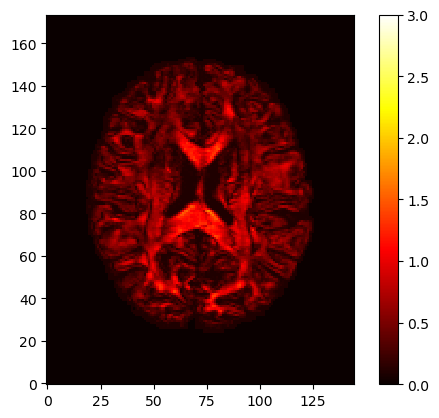

In [35]:
lambda_par_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

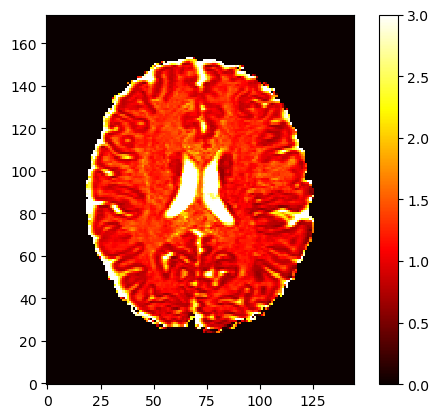

In [36]:
lambda_iso_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_iso_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_iso_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

Golden standard

In [15]:
big_b_indices_100307 = np.where(bvals_all_100307 != 5.)[0]

In [16]:
bvals_100307_no_b5 = bvals_all_100307[big_b_indices_100307]*1e-3

In [17]:
normalized_scan_100307_no_b5 = normalized_scan_100307_full[:, big_b_indices_100307]

In [18]:
n_100307_no_b5 = n_all_100307[:,big_b_indices_100307].T

In [19]:
b_values_100307 = torch.FloatTensor(bvals_100307_no_b5)
gradient_directions_100307 = torch.FloatTensor(n_100307_no_b5)

In [20]:
net_golden_std = network.BallStickNet(gradient_directions_100307, b_values_100307)
net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
net_golden_std.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [21]:
X_100307_pred_gstd,theta_100307_pred_gstd, phi_100307_pred_gstd, mu_cart_100307_pred_gstd, lambda_par_100307_pred_gstd, lambda_iso_100307_pred_gstd, volume_0_100307_pred_gstd, volume_1_100307_pred_gstd = net_golden_std(torch.from_numpy(normalized_scan_100307_no_b5.astype(np.float32)))

In [114]:
mu_cart_100307_pred_gstd

tensor([[ 0.1888,  0.5349,  0.6016,  ...,  0.5509, -0.5324, -0.4095],
        [ 0.9579,  0.4682,  0.4306,  ...,  0.8208,  0.6866,  0.8606],
        [ 0.2162, -0.7034, -0.6728,  ...,  0.1508, -0.4952, -0.3029]],
       grad_fn=<CopySlices>)

In [115]:
mu_cart_100307_pred

tensor([[-0.1650,  0.4887,  0.8054,  ...,  0.5339, -0.3313, -0.3546],
        [ 0.9636,  0.7028,  0.3473,  ...,  0.7767,  0.5606,  0.5441],
        [-0.2105, -0.5169, -0.4803,  ...,  0.3341, -0.7589, -0.7604]],
       grad_fn=<CopySlices>)

In [ ]:
mse (golden_std(a,b,c) - (a',b',c')

Mean square error

In [22]:
mse = torch.nn.MSELoss(reduction='mean')

When using half measurements

Apply model_100206_half_01.pt

In [216]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0030, grad_fn=<MseLossBackward0>)
tensor(0.0089, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)


Apply model_100206_half_02.pt

In [45]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)

In [46]:
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0046, grad_fn=<MseLossBackward0>)
tensor(0.0088, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


Apply model_100206_half_03.pt

In [128]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0034, grad_fn=<MseLossBackward0>)
tensor(0.0080, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)


Apply model_100206_half_04.pt

In [167]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0069, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)


Apply model_100206_half_05.pt

In [179]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0092, grad_fn=<MseLossBackward0>)
tensor(0.0077, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


Apply model_100206_half_06.pt

In [195]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0086, grad_fn=<MseLossBackward0>)
tensor(0.0081, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


When using 8 groups of measurements

Apply model_100206_8g_01.pt

In [86]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0059, grad_fn=<MseLossBackward0>)
tensor(0.0348, grad_fn=<MseLossBackward0>)
tensor(0.0024, grad_fn=<MseLossBackward0>)
tensor(0.0024, grad_fn=<MseLossBackward0>)


Apply model_100206_8g_02.pt

In [74]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)

In [75]:
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0043, grad_fn=<MseLossBackward0>)
tensor(0.0108, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


Apply model_100206_8g_03.pt

In [23]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0058, grad_fn=<MseLossBackward0>)
tensor(0.0098, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


When using 7 groups of measurements

Apply model_100206_7g_02.pt

In [283]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0051, grad_fn=<MseLossBackward0>)
tensor(0.0118, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)


Apply model_100206_7g_03.pt

In [60]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)

In [61]:
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0094, grad_fn=<MseLossBackward0>)
tensor(0.0110, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)


Apply model_100206_7g_04.pt

In [37]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0064, grad_fn=<MseLossBackward0>)
tensor(0.0266, grad_fn=<MseLossBackward0>)
tensor(0.0018, grad_fn=<MseLossBackward0>)
tensor(0.0018, grad_fn=<MseLossBackward0>)


When using 6 groups of measurements

In [102]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0059, grad_fn=<MseLossBackward0>)
tensor(0.0142, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)


When using 6 groups of measurements

Apply model_100206_quarter_01.pt

In [255]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0060, grad_fn=<MseLossBackward0>)
tensor(0.0184, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)


When using 1 groups of measurements

Apply model_100206_single_01.pt

In [269]:
lambda_par_mse = mse(lambda_par_100307_pred_gstd,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_gstd,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_gstd,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_gstd,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)

tensor(0.0357, grad_fn=<MseLossBackward0>)
tensor(0.0783, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)


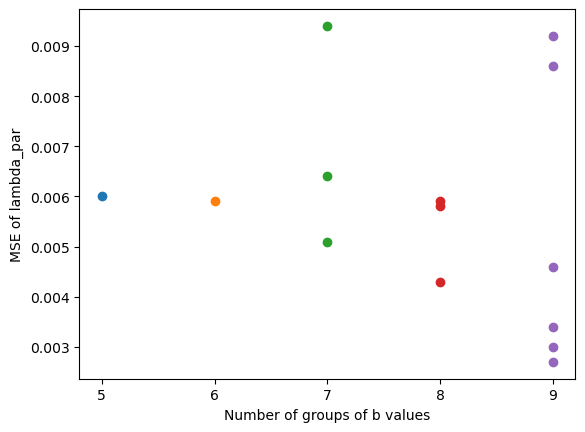

In [38]:
# x_values = [1, 5, 6, 7, 8, 9]
# y_values = [[0.0357], [0.0060], [0.0059], [0.0051, 0.0094], [0.0059, 0.0043], [0.0030, 0.0046, 0.0034, 0.0027, 0.0092, 0.0086]]
x_values = [5, 6, 7, 8, 9]
y_values = [[0.0060], [0.0059], [0.0051, 0.0094, 0.0064], [0.0059, 0.0043, 0.0058], [0.0030, 0.0046, 0.0034, 0.0027, 0.0092, 0.0086]]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of b values')
ax.set_ylabel('MSE of lambda_par')

ax.set_xticks(x_values)

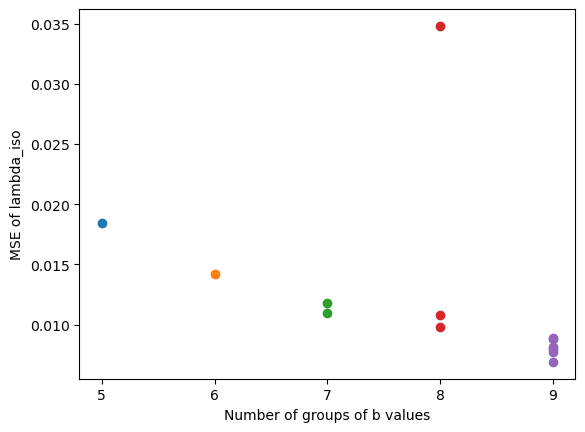

In [25]:
# x_values = [1, 5, 6, 7, 8, 9]
# y_values = [[0.0783], [0.0184], [0.0142], [0.0118, 0.0110], [0.0348, 0.0108], [0.0089, 0.0088, 0.0080, 0.0069, 0.0077, 0.0081]]
x_values = [5, 6, 7, 8, 9]
y_values = [[0.0184], [0.0142], [0.0118, 0.0110, 0.0266], [0.0348, 0.0108, 0.0098], [0.0089, 0.0088, 0.0080, 0.0069, 0.0077, 0.0081]]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of b values')
ax.set_ylabel('MSE of lambda_iso')

ax.set_xticks(x_values)

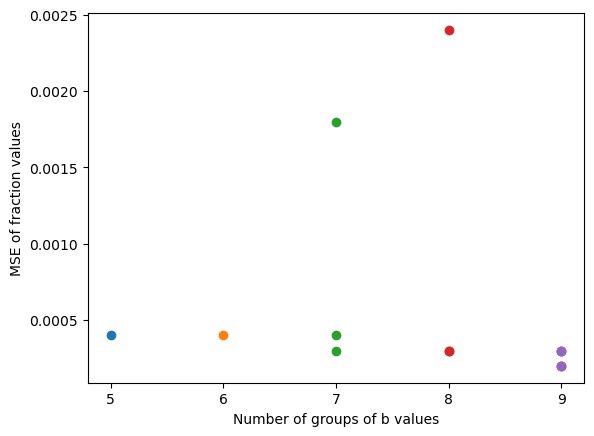

In [39]:
# x_values = [1, 5, 6, 7, 8, 9]
# y_values = [[0.0029], [0.0004], [0.0004], [0.0003, 0.0004], [0.0024, 0.0003], [0.0002, 0.0003, 0.0002, 0.0002, 0.0003, 0.0003]]
x_values = [5, 6, 7, 8, 9]
y_values = [[0.0004], [0.0004], [0.0003, 0.0004, 0.0018], [0.0024, 0.0003, 0.0003], [0.0002, 0.0003, 0.0002, 0.0002, 0.0003, 0.0003]]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i])
    
ax.set_xlabel('Number of groups of b values')
ax.set_ylabel('MSE of fraction values')

ax.set_xticks(x_values)

In [ ]:
# mean((p - mean(gtd))^2) 

In [112]:
rand_sub_bval_indice_100307 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100307, 9))

In [111]:
np.unique(bvals_all_100307[rand_sub_bval_indice_100307])

array([   5.,  990.,  995., 1000., 1005., 1985., 1990., 1995., 2000.,
       2005., 2010., 2980., 2985., 2990., 2994., 2995., 3000., 3005.,
       3010.])

In [113]:
np.unique(bvals_all_100307[rand_sub_bval_indice_100307])

array([   5.,  990.,  995., 1000., 1005., 1985., 1990., 1995., 2000.,
       2005., 2010., 2980., 2985., 2990., 2995., 3000., 3005., 3010.])

In [ ]:
# Training data 1000 2000 3000

# Testing data 3000 2000 1000